<a href="https://colab.research.google.com/github/yamini1219/NLP/blob/main/Legal_nli_Microsoft/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from torch.utils.data import DataLoader,Dataset

In [21]:
data=pd.read_csv('/content/LegalLensNLI.csv')
data.head()

,premise,hypothesis,legal_act,label
0,Consumers who used an ADP timeclock in Illinoi...,Really been enjoying that ADP timeclock at wor...,privacy,Neutral
1,"Superior Health Linens has agreed to pay $790,...",Been punching in and out with this hand scanne...,privacy,Neutral
2,DEFENDANT has agreed to pay $13 million to set...,Thoroughly enjoyed my interactions with the cu...,privacy,Neutral
3,"DEFENDANT has agreed to a $72,250 settlement t...","Y'know, it's funny how things turn out sometim...",privacy,Entailed
4,A $14 million settlement has been reached in a...,"Been loving my HelloFresh meals, y'all! Their ...",tcpa,Contradict


In [23]:
x=data[['premise','hypothesis']].astype(str)
y=data['label'].astype(str)


In [24]:
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
y_encoded=label_encoder.fit_transform(y)

In [25]:
!pip install transformers

In [26]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch


In [27]:
tokenizer=AutoTokenizer.from_pretrained('microsoft/deberta-large-mnli')
model=AutoModelForSequenceClassification.from_pretrained('microsoft/deberta-large-mnli',num_labels=3)

Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
x_tokenized=tokenizer(list(x['premise']),list(x['hypothesis']),padding=True,truncation=True,return_tensors='pt')

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [29]:
# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

#create dataset instance
dataset=CustomDataset(x_tokenized,y_encoded)


In [30]:
#create DataLoader
dataloader = DataLoader(dataset, batch_size=2, shuffle=False)

In [31]:
!pip install torch


Accuracy: 0.4551


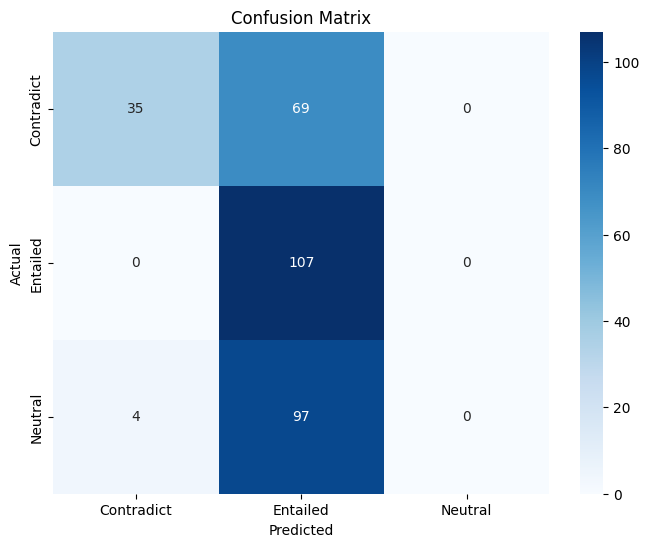

In [32]:
import torch
import seaborn as sns

def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']
            outputs = model(input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs.logits, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return np.array(y_true), np.array(y_pred)

# Evaluate model
y_true, y_pred = evaluate_model(model, dataloader)

# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()